In [54]:
from lib import *
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller

year = 2023
taxi_type = GREEN

DR.setTable(year, taxi_type)
table_name = DR.getTableName()
u_table_name = DR.getTableName('uniq_')

sql = f"""
select *,
    (unixepoch(dropoff_datetime)-unixepoch(pickup_datetime)) as trip_duration
 from {u_table_name} 
 where (strftime('%Y', pickup_datetime))='{year}' and
    trip_duration > 0 AND trip_duration <= 7200
"""

df = getDF(text(sql))

In [48]:
# Assuming df is your dataset
# Convert the pickup datetime column to datetime if it's not already
df['pickup_datetime'] = pd.to_datetime(df['pickup_datetime'])

# Set the datetime column as the index
df.set_index('pickup_datetime', inplace=True)

In [49]:
daily_data = df['f_total_amount'].resample('D').mean()  # Resample to daily and average total_amount
daily_data = daily_data.dropna()
daily_data = daily_data.diff().dropna()

daily_data = daily_data + abs(daily_data.min()) + 1
# print(daily_data)

# daily_data.min()


# Apply log transformation
# daily_data = np.sqrt(daily_data)


In [3]:
hourly_data = df['f_total_amount'].resample('H').mean()  # Resample to hourly and average total_amount
hourly_data = hourly_data.dropna()

In [82]:
# linear regression feature selection
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

feats = [
    'trip_duration',
    'f_trip_distance',
    'f_passenger_count',
    'tip_amount','tolls_amount','extra',
    'improvement_surcharge','congestion_surcharge',
    'f_fare_amount',
    'f_mta_tax'
 ]
dep = 'f_total_amount'

# Function to calculate VIF for each feature
def calculate_vif(X):
    vif = pd.DataFrame()
    vif["Feature"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return vif

def stepwise_vif_selection(X, threshold=10):
    while True:
        # Calculate VIF for all features
        vif = calculate_vif(X)
        max_vif = vif["VIF"].max()
        if max_vif > threshold:
            # Drop the feature with the highest VIF
            feature_to_remove = vif.loc[vif["VIF"].idxmax(), "Feature"]
            print(f"Removing feature: {feature_to_remove} with VIF = {max_vif}")
            X = X.drop(columns=[feature_to_remove])
        else:
            # If all VIFs are below the threshold, stop the loop
            break
    return X

# train, test = train_test_split(df, test_size=0.2)

X = df[feats]
y = df[dep]

# Add a constant to the features (for the intercept)
X = sm.add_constant(X)

# Perform stepwise VIF feature selection
X = stepwise_vif_selection(X)
print("Selected Features after VIF Selection:")
print(X.columns)

Removing feature: const with VIF = 86.19884754209538
Removing feature: f_fare_amount with VIF = 17.66294899541249
Selected Features after VIF Selection:
Index(['trip_duration', 'f_trip_distance', 'f_passenger_count', 'tip_amount',
       'tolls_amount', 'extra', 'improvement_surcharge',
       'congestion_surcharge', 'f_mta_tax'],
      dtype='object')


Mean Squared Error: 53.148839598926614
R-squared: 0.7706740249237116


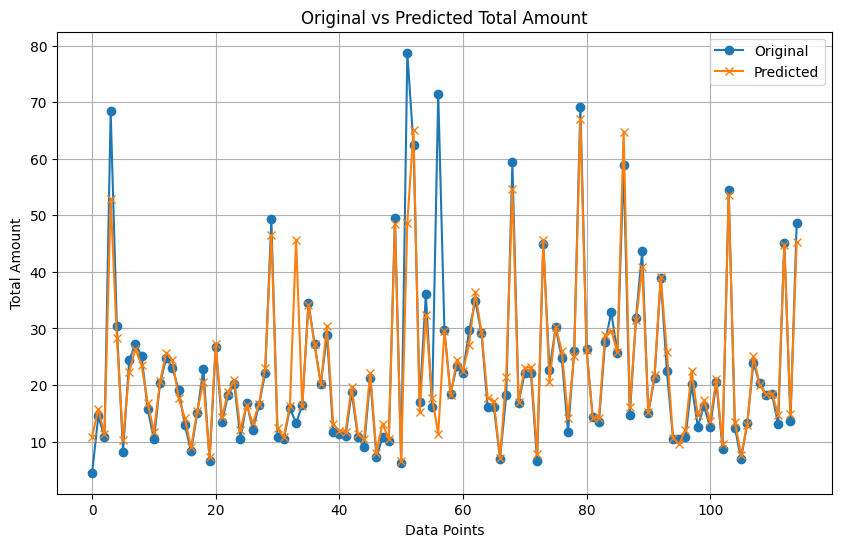

In [83]:
# linear regression forecasting
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

# Split data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.00015, random_state=42)

# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Squared Error: {mse}')
print(f'R-squared: {r2}')

# Plot the forecasted total_amount against the original total_amount
plt.figure(figsize=(10, 6))

# Plot original values
plt.plot(y_test.values, label='Original', marker='o')

# Plot predicted values
plt.plot(y_pred, label='Predicted', marker='x')

# Add labels and title
plt.xlabel('Data Points')
plt.ylabel('Total Amount')
plt.title('Original vs Predicted Total Amount')
plt.legend()
plt.grid(True)
plt.show()


In [50]:
# holtwinters
from statsmodels.tsa.holtwinters import ExponentialSmoothing

data = daily_data
# seasonal_periods = 24 * 7
seasonal_periods = 7

# Fit the Holt-Winters model
hw_model = ExponentialSmoothing(data, 
                                trend='add',  # Additive trend
                                seasonal='add',  # Additive seasonality
                                seasonal_periods=seasonal_periods).fit()
# Print the model summary
# print(hw_model.summary())
print('hw model ready')


hw model ready


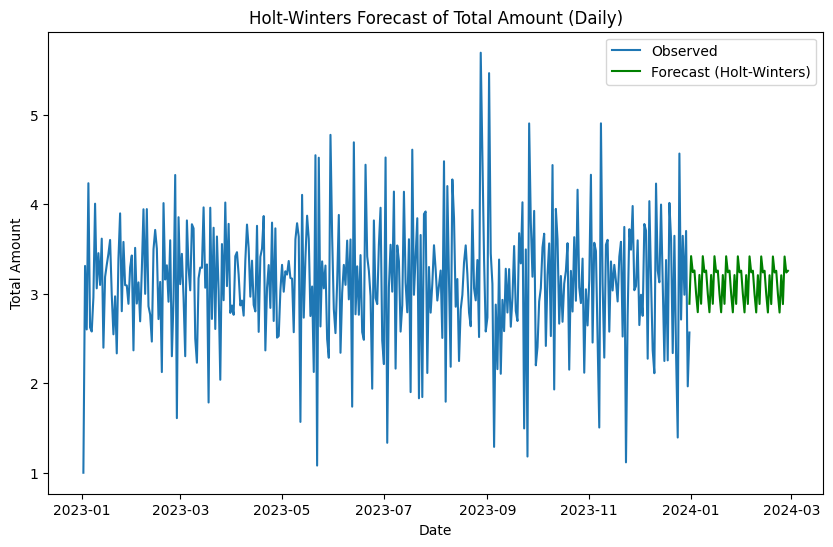

In [51]:
# Forecast for the next 48 hours
# forecast_steps = 24 * 30
forecast_steps = 2*30
hw_forecast = hw_model.forecast(steps=forecast_steps)

# Plot the original data and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(data.index, data, label='Observed')
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps, freq='D')
plt.plot(forecast_index, hw_forecast, label='Forecast (Holt-Winters)', color='green')

plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.title('Holt-Winters Forecast of Total Amount (Daily)')
plt.legend()
plt.show()

/Users/njpate/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


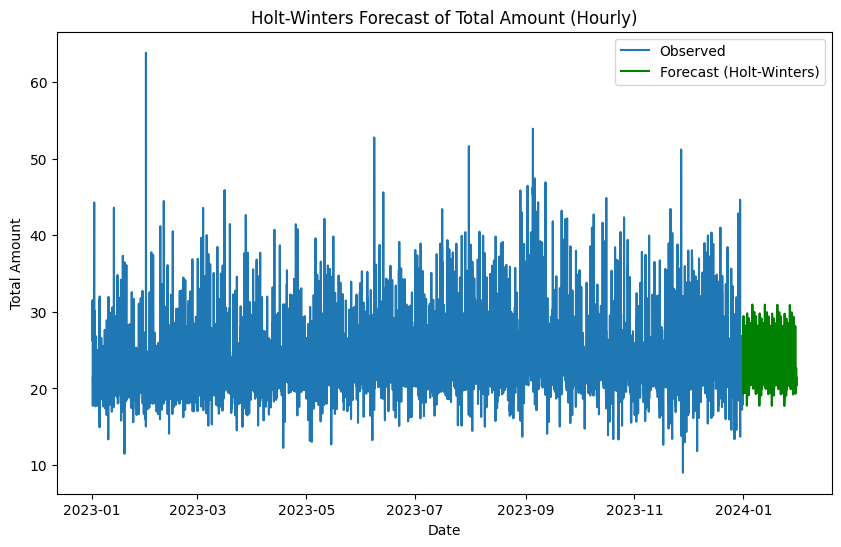

In [7]:
# Forecast for the next 48 hours
forecast_steps = 24 * 30
hw_forecast = hw_model.forecast(steps=forecast_steps)

# Plot the original data and the forecasted values
plt.figure(figsize=(10, 6))
plt.plot(data.index, data, label='Observed')
forecast_index = pd.date_range(start=data.index[-1], periods=forecast_steps, freq='H')
plt.plot(forecast_index, hw_forecast, label='Forecast (Holt-Winters)', color='green')

plt.xlabel('Date')
plt.ylabel('Total Amount')
plt.title('Holt-Winters Forecast of Total Amount (Hourly)')
plt.legend()
plt.show()

In [106]:

# Function to perform ADF test
def adf_test(series):
    result = adfuller(series)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    if result[1] <= 0.05:
        print("The series is stationary")
    else:
        print("The series is not stationary")

# Perform ADF test on the weekly data
# adf_test(weekly_data)

print('hourly data')
adf_test(hourly_data)

# Perform ADF test on the hourly data
# hourly_data = hourly_data.dropna()
# daily_data = daily_data.diff().dropna()
print('daily data')
adf_test(daily_data)


# Apply differencing if necessary
# diff_weekly_data = weekly_data.diff().dropna()
# adf_test(diff_weekly_data)



hourly data
ADF Statistic: -7.6146262170984915
p-value: 2.20854683647418e-11
The series is stationary
daily data
ADF Statistic: -7.8893038514676155
p-value: 4.48098024729445e-12
The series is stationary


In [145]:
# Fit the SARIMA model
p, d, q = 1, 0, 12  # Initial ARIMA parameters
P, D, Q, m = 1, 1, 1, 168   # Seasonal parameters (m=52 for weekly seasonality)

model = SARIMAX(hourly_data, 
                # order=(p, d, q), 
                seasonal_order=(P, D, Q, m),
                # trend='ct',
                enforce_stationarity=False, 
                enforce_invertibility=False)

sarima_result = model.fit(disp=False)

# Print model summary
print(sarima_result.summary())

# Fit the SARIMA model with daily data
# p, d, q = 1, 0, 1  # Initial ARIMA parameters
# P, D, Q, m = 1, 1, 1, 7  # Seasonal parameters (m=168 for weekly seasonality in hourly data)

# model = SARIMAX(daily_data, 
#                 # order=(p, d, q), 
#                 trend='t',
#                 seasonal_order=(P, D, Q, m),
#                 enforce_stationarity=False, 
#                 enforce_invertibility=False)

# sarima_result = model.fit(disp=False)

# # Print model summary
# print(sarima_result.summary())


/Users/njpate/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/Users/njpate/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


: 

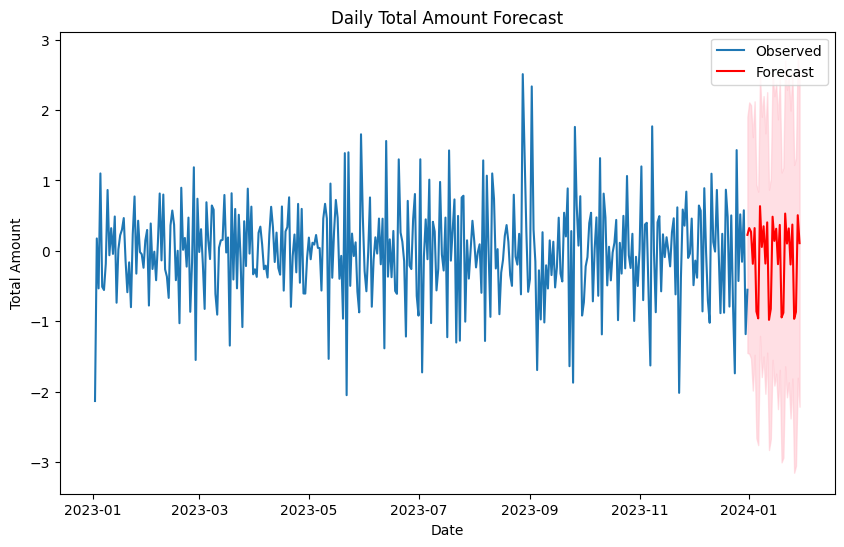

In [144]:
# # Forecast future values
# forecast_steps = 1*30  # Number of future weeks to forecast
# forecast = sarima_result.get_forecast(steps=forecast_steps)

# # Get confidence intervals for the forecast
# forecast_ci = forecast.conf_int()

# # Plot the forecast
# plt.figure(figsize=(10, 6))
# plt.plot(daily_data.index, daily_data, label='Observed')
# forecast_index = pd.date_range(start=daily_data.index[-1], periods=forecast_steps, freq='D')
# plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red')

# # Plot confidence intervals
# plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.5)

# plt.xlabel('Date')
# plt.ylabel('Total Amount')
# plt.title('Daily Total Amount Forecast')
# plt.legend()
# plt.show()


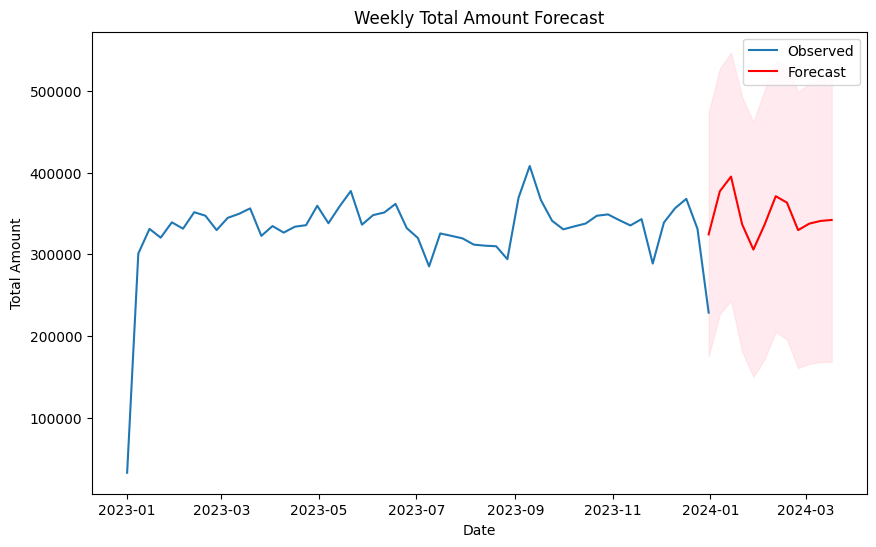

In [97]:
# # Forecast future values
# forecast_steps = 12  # Number of future weeks to forecast
# forecast = sarima_result.get_forecast(steps=forecast_steps)

# # Get confidence intervals for the forecast
# forecast_ci = forecast.conf_int()

# # Plot the forecast
# plt.figure(figsize=(10, 6))
# plt.plot(weekly_data.index, weekly_data, label='Observed')
# forecast_index = pd.date_range(start=weekly_data.index[-1], periods=forecast_steps, freq='W')
# plt.plot(forecast_index, forecast.predicted_mean, label='Forecast', color='red')

# # Plot confidence intervals
# plt.fill_between(forecast_index, forecast_ci.iloc[:, 0], forecast_ci.iloc[:, 1], color='pink', alpha=0.3)

# plt.xlabel('Date')
# plt.ylabel('Total Amount')
# plt.title('Weekly Total Amount Forecast')
# plt.legend()
# plt.show()


In [ ]:
# holt winters
